In [12]:
# gan모델 생성자 만들기
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, UpSampling2D, BatchNormalization, Reshape, Flatten, Dropout, Activation, LeakyReLU, Input

import matplotlib.pyplot as plt

In [7]:
# 생성자 모델 만들기

generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2))) # 노이즈 이미지 생성
generator.add(BatchNormalization()) # 데이터의 정규화 작업: 분산 1, 평균 0
generator.add(Reshape((7,7,128))) # Conv에 입력 가능한 자료로 변환
generator.add(UpSampling2D()) # 이미지 확대 : 14*14
generator.add(Conv2D(64, kernel_size= 5, padding = 'same')) # 14*14, size 변동 없음
generator.add(BatchNormalization()) # 데이터 정규화
generator.add(Activation(LeakyReLU(0.2))) # 활성화 함수 : LeakyReLU
generator.add(UpSampling2D()) # 이미지 확대 28*28
generator.add(Conv2D(1,kernel_size = 5, padding= 'same', activation = 'tanh')) # 
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_3 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)      

In [8]:
# 모델 이름을 discriminator로 정하고 Sequential() 함수를 호출합니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28,28,1), padding = 'same')) # 14*14*64
discriminator.add(Activation(LeakyReLU(0.2))) # 활성화 함수 지정
discriminator.add(Dropout(0.3)) # 30%노드를 까줌
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same')) # 7*7*128
discriminator.add(Activation(LeakyReLU(0.2))) # 활성화 함수 지정
discriminator.add(Dropout(0.3)) # 30%노드를 까줌
discriminator.add(Flatten()) # 1차원으로 평탄화
discriminator.add(Dense(1, activation = 'sigmoid'))

discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_2 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_3 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [9]:
from tensorflow.keras.datasets import mnist

In [10]:
(X_train, y_train), (_,_) = mnist.load_data()

X_train.shape

(60000, 28, 28)

In [14]:
import numpy as np

# 생성자와 판별자 모델을 연결시켜주는 gan 모델 생성
ginput = Input(shape = (100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [22]:
# 학습하는 함수 생성

def gan_train(epoch, batch_size, saving_interval):
    # mnist_data 불러오기
    (X_train,_),(_,_) = mnist.load_data() # mnist 데이터 셋에서 x_train데이터만 사용
    
    # conv2d를 사용하기 위해 3차원 배열로 shape 변환
    X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32') # 60000,28,28,1의 형식
    
    # 각 픽셀의 값을 -1에서 1로 변환 (활성화 함수 : tanh이므로 0~255값을 변환 시킴)
    X_train = (X_train - 127.5) / 127.5
    
    # batch_size 만큼 참인 배열, fake자료을 생성
    true = np.ones((batch_size,1)) # shape(batch_size,1)의 형식
    fake = np.zeros((batch_size,1)) # shape(batch_size,1)의 형식
    
    for i in range(epoch):
        # 실제 데이터 학습
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 0~60000개의 숫자중 batch_size만큼 정수 추출
        imgs = X_train[idx] # 랜덤으로 이미지 추출
        d_loss_real = discriminator.train_on_batch(imgs, true) # 레이블이 1인 자료 학습
        
        #가상 이미지 학습
        noise = np.random.normal(0,1,(batch_size, 100)) # 생성자에 넣을 가상의 이미지를 생성
        gen_img = generator.predict(noise) # 가상의 이미지
        d_loss_fake = discriminator.train_on_batch(gen_img, fake) # 가짜 자료 학습
    
        # 판별치의 오차
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
        # 판별자와 생성자를 연결해서 만든 모델 -> gan -> 오차를 구함 (g_loss)
        g_loss = gan.train_on_batch(noise, true)
    
        print(f'epoch : {epoch}, d_loss : {d_loss:.4f}, g_loss : {g_loss:.4f}')
        
        if i % saving_interval == 0:
            gen_idx = np.random.randint(0, len(gen_img), 25)  
            gen_show = gen_img[gen_idx] # 생성된 이미지를 랜덤으로 25개 추출
                       
            fig,axs = plt.subplots(5,5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_show[count, :, :, 0], cmap='Greys')
                    axs[j,k].axis('off')
                    count += 1
            fig.savefig("./data/gan_images/gan_mnist_{:d}.png".format(i))

1/1 [==============================] - 0s 44ms/step
epoch : 2001, d_loss : 0.4744, g_loss : 0.1693
1/1 [==============================] - 0s 42ms/step
epoch : 2001, d_loss : 0.4622, g_loss : 0.3073
1/1 [==============================] - 0s 38ms/step
epoch : 2001, d_loss : 0.4569, g_loss : 0.4660
1/1 [==============================] - 0s 40ms/step
epoch : 2001, d_loss : 0.4673, g_loss : 0.5603
1/1 [==============================] - 0s 39ms/step
epoch : 2001, d_loss : 0.5098, g_loss : 0.5215
1/1 [==============================] - 0s 41ms/step
epoch : 2001, d_loss : 0.5578, g_loss : 0.3391
1/1 [==============================] - 0s 38ms/step
epoch : 2001, d_loss : 0.5289, g_loss : 0.2040
1/1 [==============================] - 0s 56ms/step
epoch : 2001, d_loss : 0.4825, g_loss : 0.1261
1/1 [==============================] - 0s 38ms/step
epoch : 2001, d_loss : 0.4249, g_loss : 0.0846
1/1 [==============================] - 0s 59ms/step
epoch : 2001, d_loss : 0.3631, g_loss : 0.0587
1/1 [=====

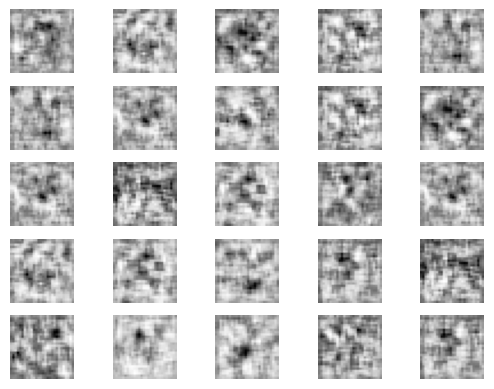

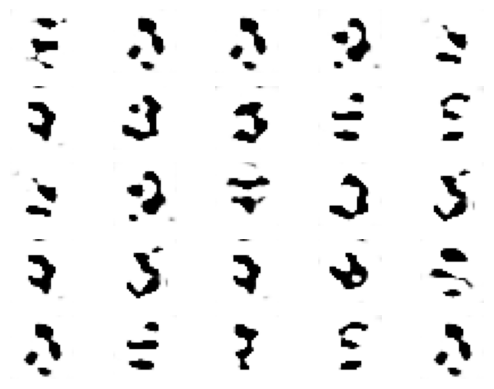

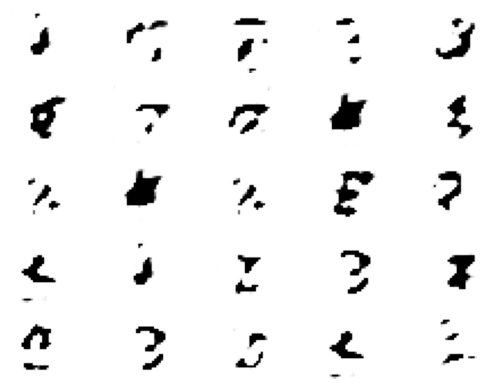

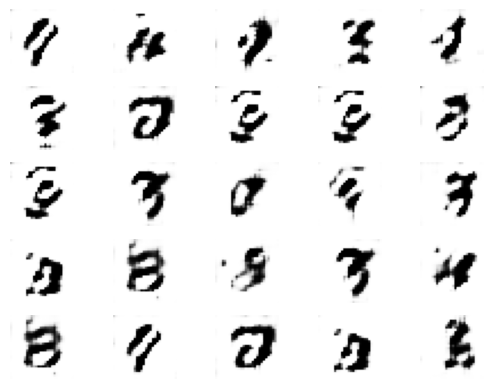

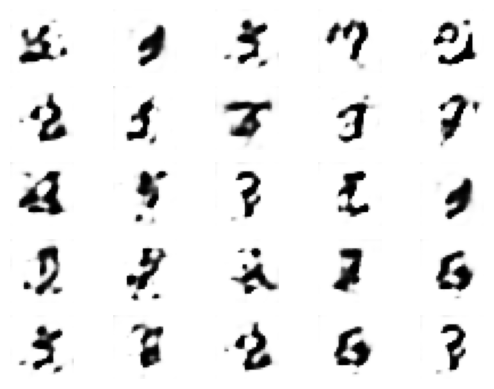

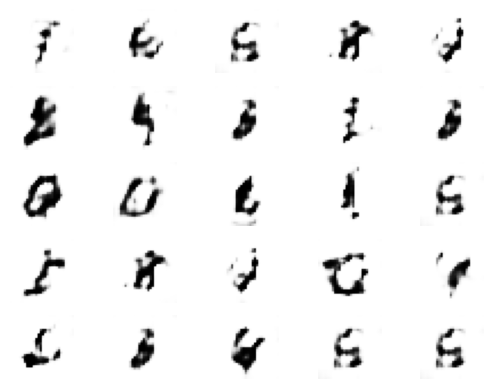

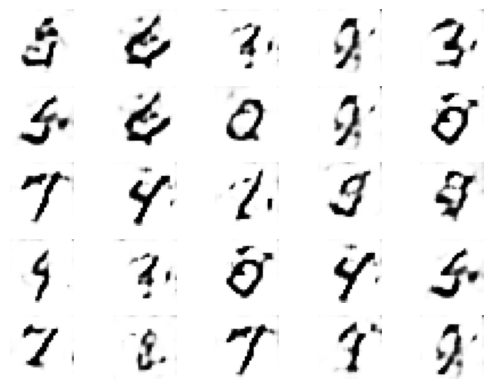

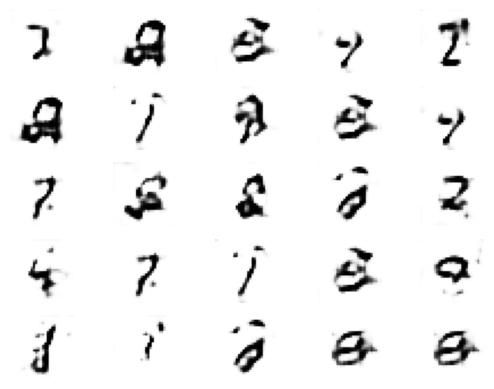

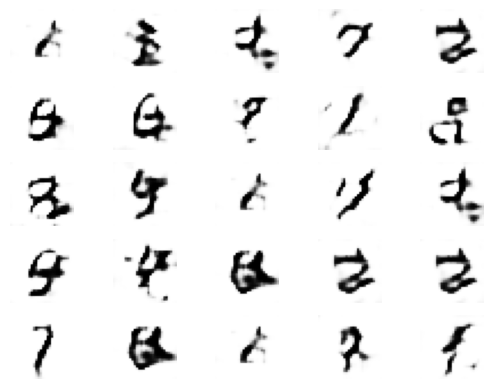

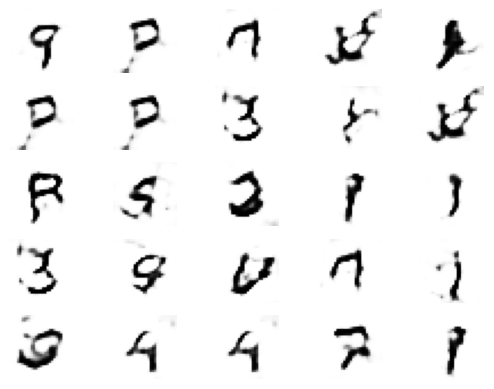

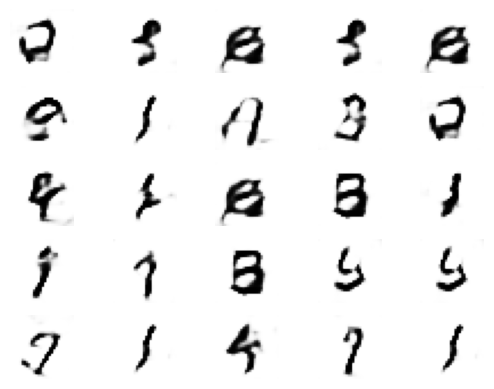

In [24]:
gan_train(2001, 32, 200)

1/1 [==============================] - 0s 56ms/step
epoch : 3001, d_loss : 0.5834, g_loss : 1.5021
1/1 [==============================] - 0s 40ms/step
epoch : 3001, d_loss : 0.5475, g_loss : 1.4202
1/1 [==============================] - 0s 40ms/step
epoch : 3001, d_loss : 0.6520, g_loss : 1.4819
1/1 [==============================] - 0s 40ms/step
epoch : 3001, d_loss : 0.6142, g_loss : 1.4830
1/1 [==============================] - 0s 38ms/step
epoch : 3001, d_loss : 0.6778, g_loss : 1.2460
1/1 [==============================] - 0s 43ms/step
epoch : 3001, d_loss : 0.4670, g_loss : 1.6481
1/1 [==============================] - 0s 36ms/step
epoch : 3001, d_loss : 0.6151, g_loss : 1.5952
1/1 [==============================] - 0s 66ms/step
epoch : 3001, d_loss : 0.5388, g_loss : 1.7564
1/1 [==============================] - 0s 39ms/step
epoch : 3001, d_loss : 0.5559, g_loss : 1.5795
1/1 [==============================] - 0s 40ms/step
epoch : 3001, d_loss : 0.4182, g_loss : 1.6573
1/1 [=====

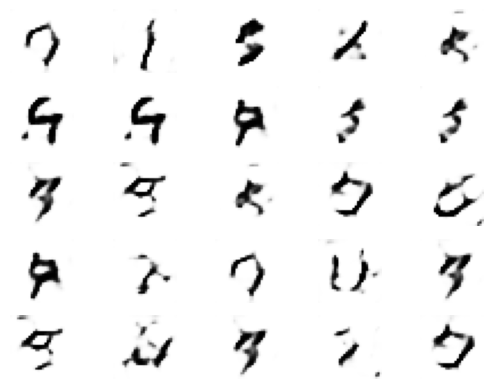

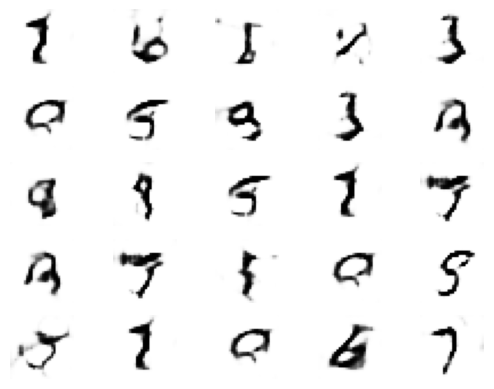

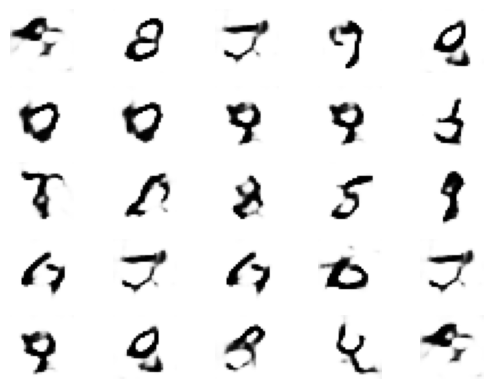

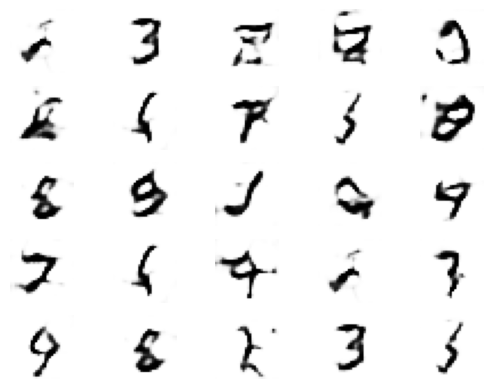

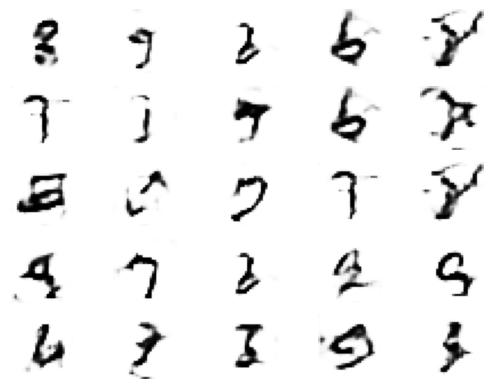

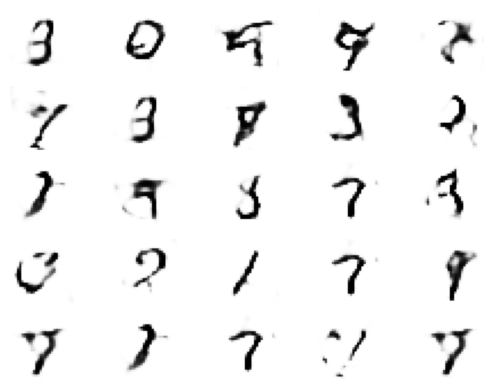

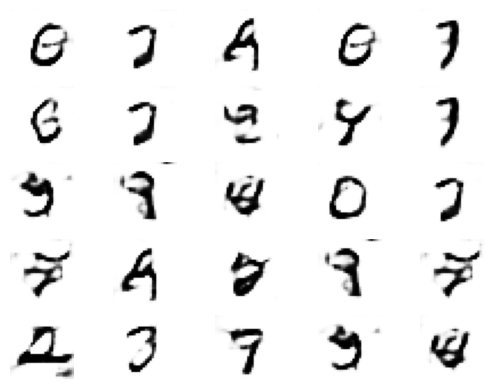

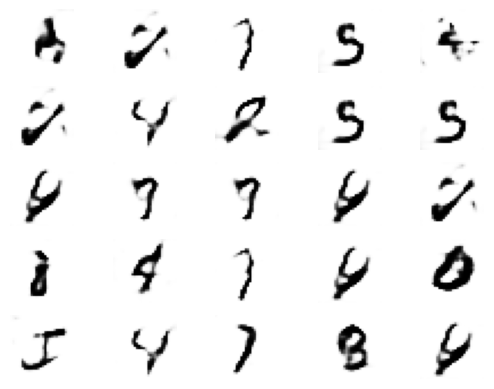

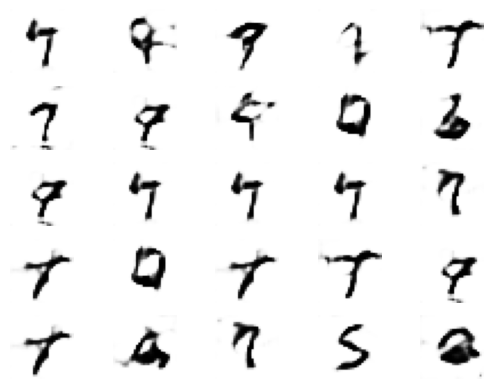

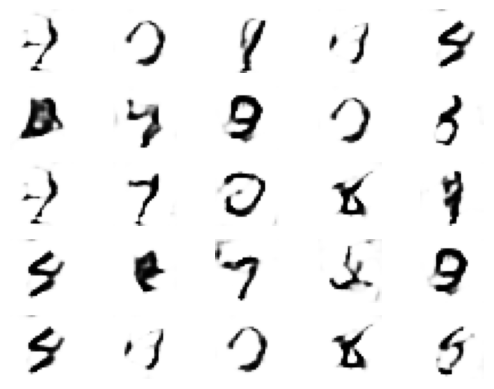

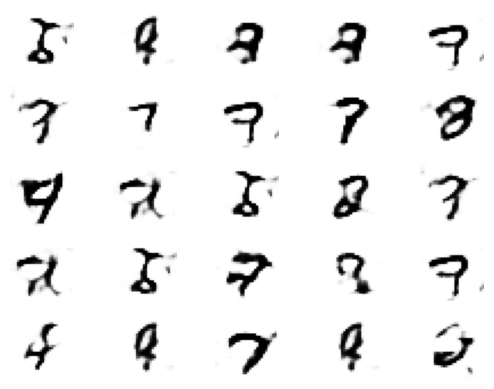

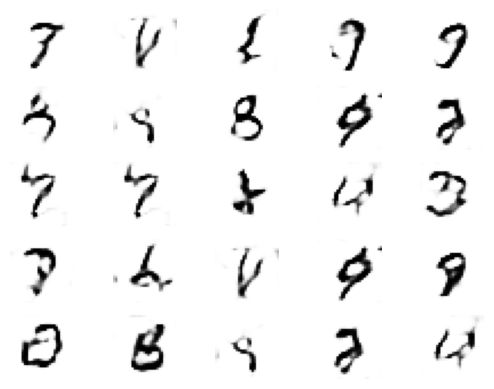

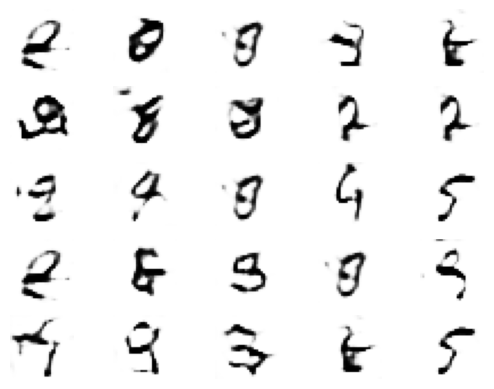

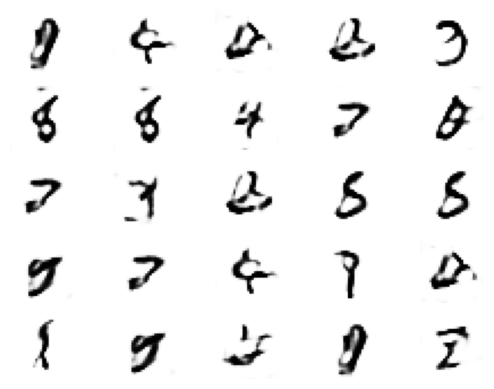

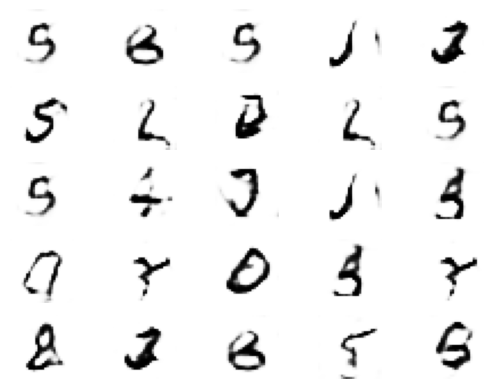

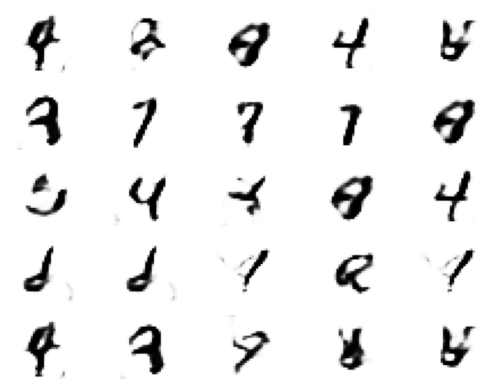

In [25]:
gan_train(3001, 32, 200)

In [26]:
(X_train,_),(_,_) = mnist.load_data()

X_train.shape

(60000, 28, 28)

In [27]:
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32')

X_train.shape

(60000, 28, 28, 1)

In [28]:
from tensorflow.keras.datasets import fashion_mnist

In [29]:
(X_train,_),(_,_) = fashion_mnist.load_data()
X_train.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [30]:
# 학습하는 함수 생성

def gan_train_fashion(epoch, batch_size, saving_interval):
    # mnist_data 불러오기
    (X_train,_),(_,_) = fashion_mnist.load_data() # mnist 데이터 셋에서 x_train데이터만 사용
    
    # conv2d를 사용하기 위해 3차원 배열로 shape 변환
    X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32') # 60000,28,28,1의 형식
    
    # 각 픽셀의 값을 -1에서 1로 변환 (활성화 함수 : tanh이므로 0~255값을 변환 시킴)
    X_train = (X_train - 127.5) / 127.5
    
    # batch_size 만큼 참인 배열, fake자료을 생성
    true = np.ones((batch_size,1)) # shape(batch_size,1)의 형식
    fake = np.zeros((batch_size,1)) # shape(batch_size,1)의 형식
    
    for i in range(epoch):
        # 실제 데이터 학습
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 0~60000개의 숫자중 batch_size만큼 정수 추출
        imgs = X_train[idx] # 랜덤으로 이미지 추출
        d_loss_real = discriminator.train_on_batch(imgs, true) # 레이블이 1인 자료 학습
        
        #가상 이미지 학습
        noise = np.random.normal(0,1,(batch_size, 100)) # 생성자에 넣을 가상의 이미지를 생성
        gen_img = generator.predict(noise) # 가상의 이미지
        d_loss_fake = discriminator.train_on_batch(gen_img, fake) # 가짜 자료 학습
    
        # 판별치의 오차
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
        # 판별자와 생성자를 연결해서 만든 모델 -> gan -> 오차를 구함 (g_loss)
        g_loss = gan.train_on_batch(noise, true)
    
        print(f'epoch : {epoch}, d_loss : {d_loss:.4f}, g_loss : {g_loss:.4f}')
        
        if i % saving_interval == 0:
            gen_idx = np.random.randint(0, len(gen_img), 25)  
            gen_show = gen_img[gen_idx] # 생성된 이미지를 랜덤으로 25개 추출
                       
            fig,axs = plt.subplots(5,5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_show[count, :, :, 0], cmap='Greys')
                    axs[j,k].axis('off')
                    count += 1
            fig.savefig("./data/gan_fashion/gan_mnist_fashion_{:d}.png".format(i))

1/1 [==============================] - 0s 63ms/step
epoch : 3001, d_loss : 4.5995, g_loss : 2.1156
1/1 [==============================] - 0s 64ms/step
epoch : 3001, d_loss : 3.0359, g_loss : 2.0361
1/1 [==============================] - 0s 70ms/step
epoch : 3001, d_loss : 2.3777, g_loss : 1.7099
1/1 [==============================] - 0s 70ms/step
epoch : 3001, d_loss : 1.6915, g_loss : 1.5509
1/1 [==============================] - 0s 68ms/step
epoch : 3001, d_loss : 1.1014, g_loss : 1.8076
1/1 [==============================] - 0s 84ms/step
epoch : 3001, d_loss : 0.5425, g_loss : 2.7297
1/1 [==============================] - 0s 65ms/step
epoch : 3001, d_loss : 0.5064, g_loss : 3.4494
1/1 [==============================] - 0s 68ms/step
epoch : 3001, d_loss : 0.5442, g_loss : 3.6049
1/1 [==============================] - 0s 63ms/step
epoch : 3001, d_loss : 0.5050, g_loss : 4.1956
1/1 [==============================] - 0s 66ms/step
epoch : 3001, d_loss : 0.5655, g_loss : 3.6838
1/1 [=====

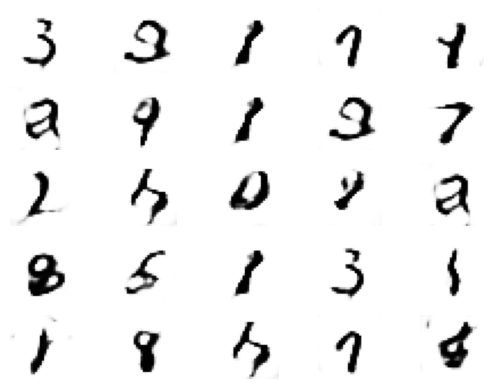

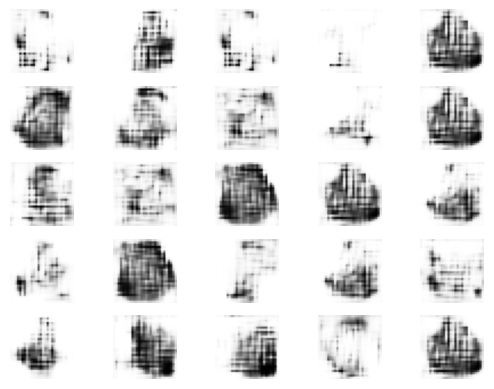

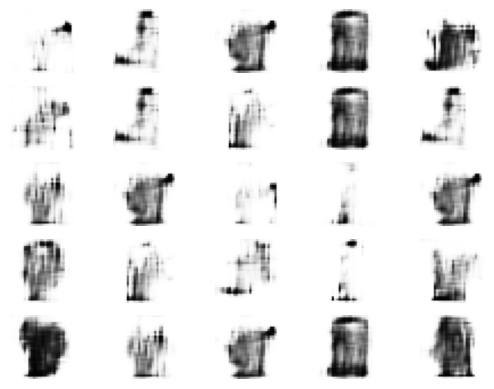

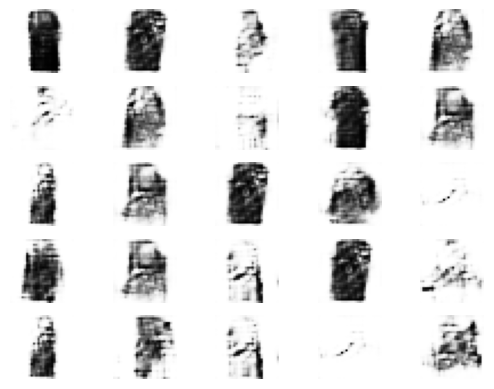

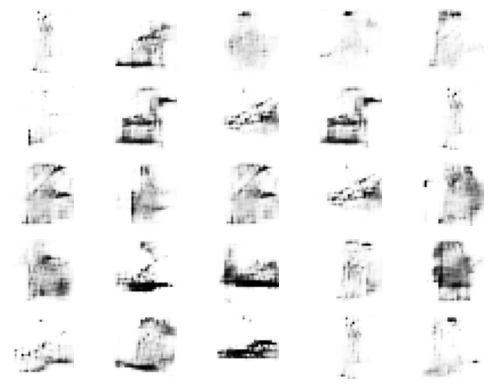

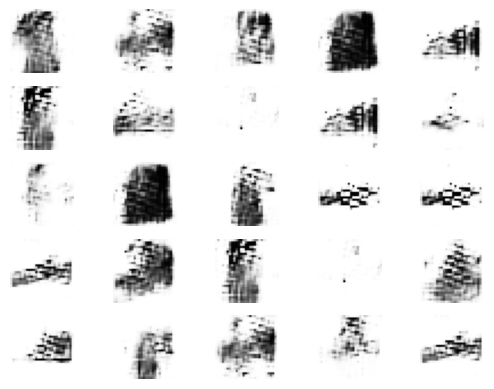

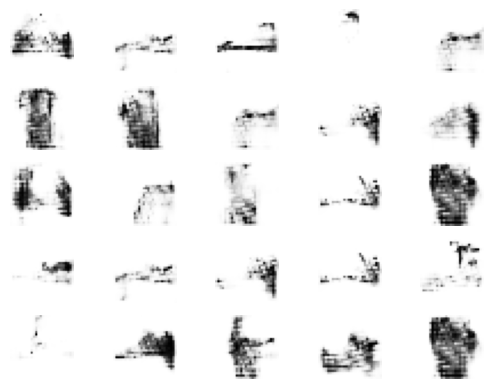

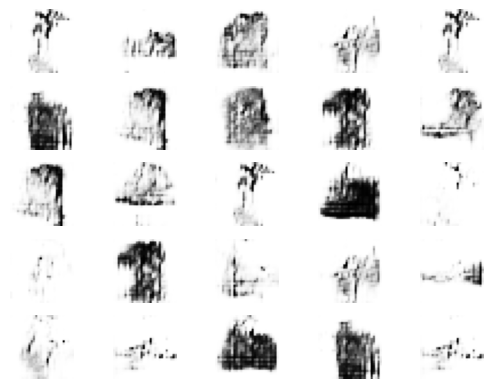

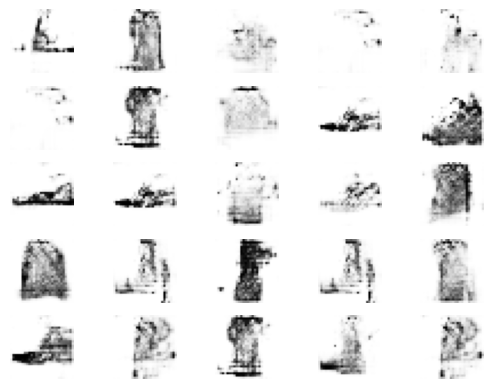

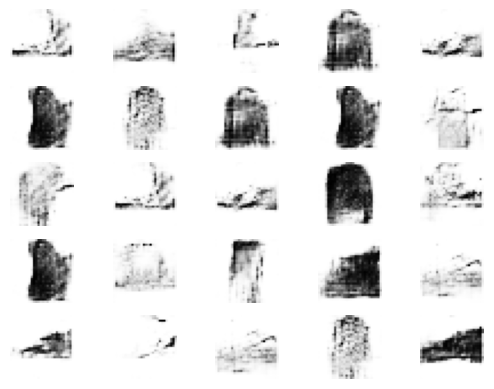

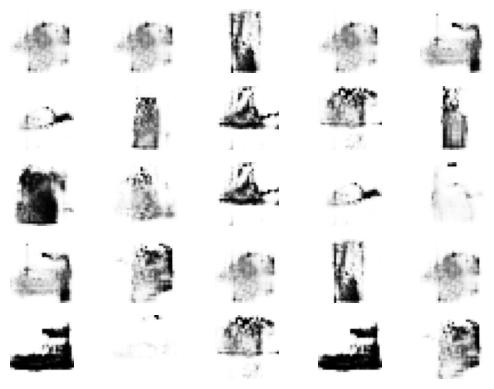

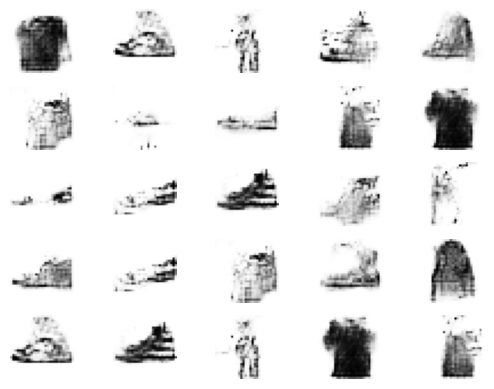

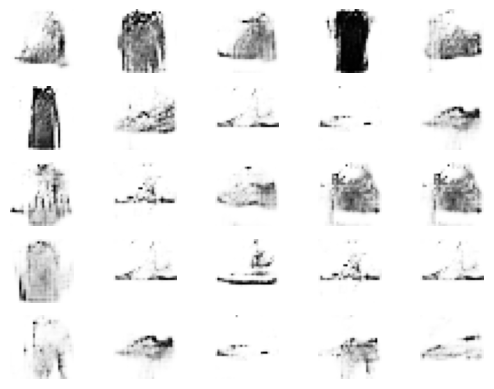

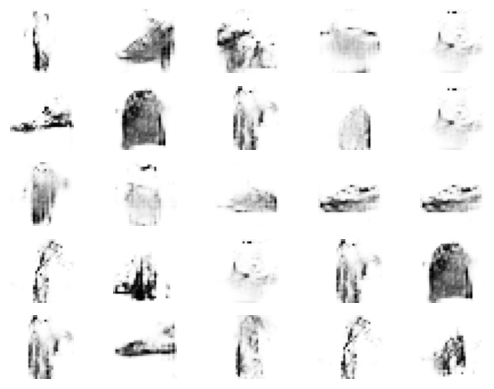

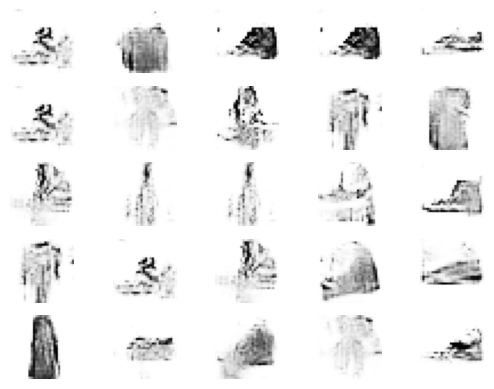

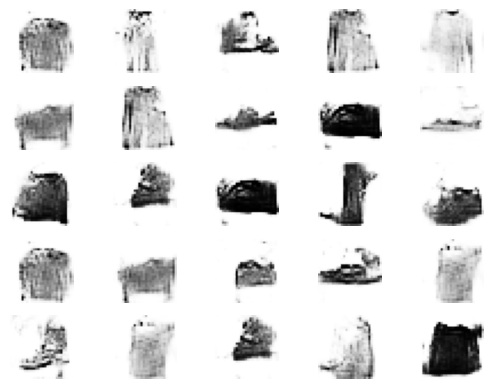

In [31]:
gan_train_fashion(3001,32,200)

In [1]:
import numpy as np
from keras.datasets import mnist

(x_train_2d, _), (_, _) = mnist.load_data()
x_train_2d = x_train_2d.astype(np.float32) / 255.0
x_train = x_train_2d.reshape(-1, np.prod(x_train_2d.shape[1:])) 

import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Sequential

input_dim = x_train.shape[1]
encoding_dim = 32

autoencoder1 = Sequential()
autoencoder1.add(Dense(encoding_dim, input_dim=input_dim, activation='relu'))
autoencoder1.add(Dense(input_dim, activation='sigmoid'))
autoencoder1.compile(optimizer="adadelta", loss="binary_crossentropy")

In [3]:

history = autoencoder1.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, verbose=0)

1/1 [==============================] - 0s 22ms/step


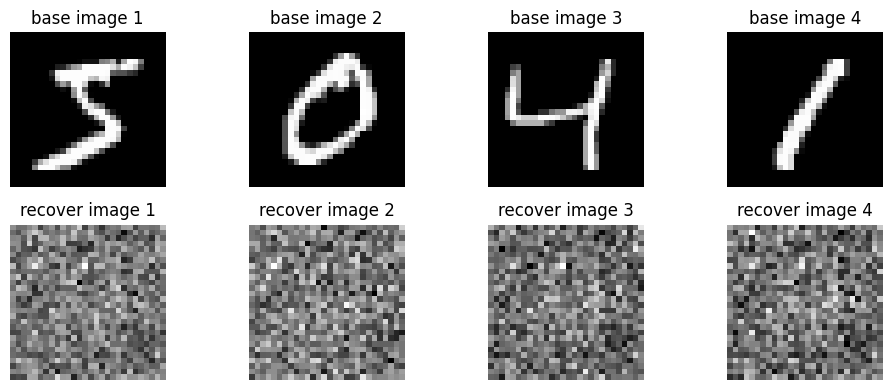

In [6]:
import matplotlib.pyplot as plt

plt.rc('axes', unicode_minus = False)

n = 4
x_train_recoverd = autoencoder1.predict(x_train[:n, :])
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i, :].reshape(28, 28))
    plt.title("base image {}".format(i + 1))
    plt.gray(); plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_recoverd[i, :].reshape(28, 28))
    plt.title("recover image {}".format(i + 1))
    plt.gray(); plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Model



In [11]:
encoding_dim1 = 128
encoding_dim2 = 64
encoding_dim3 = 32

autoencoder2 = Sequential()
autoencoder2.add(Dense(encoding_dim1, input_dim=input_dim, activation='relu'))
autoencoder2.add(Dense(encoding_dim2, activation='relu'))
autoencoder2.add(Dense(encoding_dim3, activation='relu'))
autoencoder2.add(Dense(encoding_dim2, activation='relu'))
autoencoder2.add(Dense(encoding_dim1, activation='relu'))
autoencoder2.add(Dense(input_dim, activation='sigmoid'))
autoencoder2.compile(optimizer="adam", loss="binary_crossentropy")

In [12]:
history = autoencoder2.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, verbose=0)

1/1 [==============================] - 0s 71ms/step


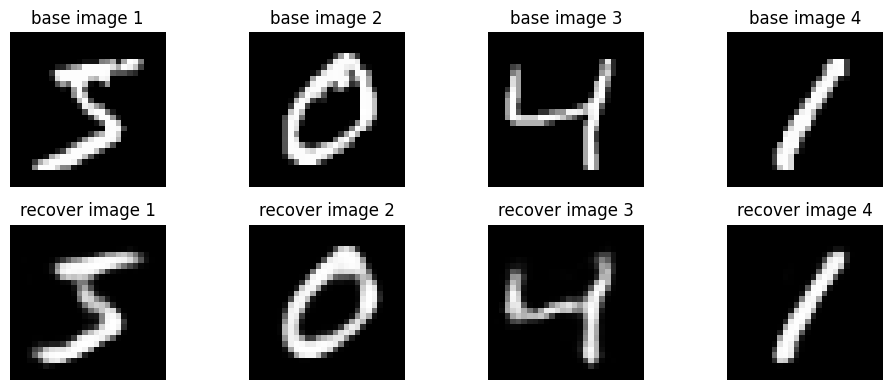

In [13]:
n = 4
x_train_recoverd = autoencoder2.predict(x_train[:n, :])
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i, :].reshape(28, 28))
    plt.title("base image {}".format(i + 1))
    plt.gray(); plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_recoverd[i, :].reshape(28, 28))
    plt.title("recover image {}".format(i + 1))
    plt.gray(); plt.axis("off")

plt.tight_layout()
plt.show()

In [14]:
x_train_2d_c = np.expand_dims(x_train_2d, -1)
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

autoencoder3 = Sequential()

In [15]:
autoencoder3.add(Conv2D(16, 3, input_shape=(28, 28, 1), activation='relu', padding='same'))
autoencoder3.add(MaxPooling2D(2, padding='same'))
autoencoder3.add(Conv2D(32, 3, activation='relu', padding='same'))
autoencoder3.add(MaxPooling2D(2, padding='same'))

autoencoder3.add(UpSampling2D(2))
autoencoder3.add(Conv2D(16, 3, activation='relu', padding='same'))
autoencoder3.add(UpSampling2D(2))
autoencoder3.add(Conv2D(1, 3, activation='relu', padding='same'))

autoencoder3.compile(optimizer="adam", loss="binary_crossentropy")

autoencoder3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                      

In [16]:
history = autoencoder3.fit(x_train_2d_c, x_train_2d_c, 
                           epochs=10, batch_size=256, shuffle=True, verbose=0)

1/1 [==============================] - 0s 67ms/step


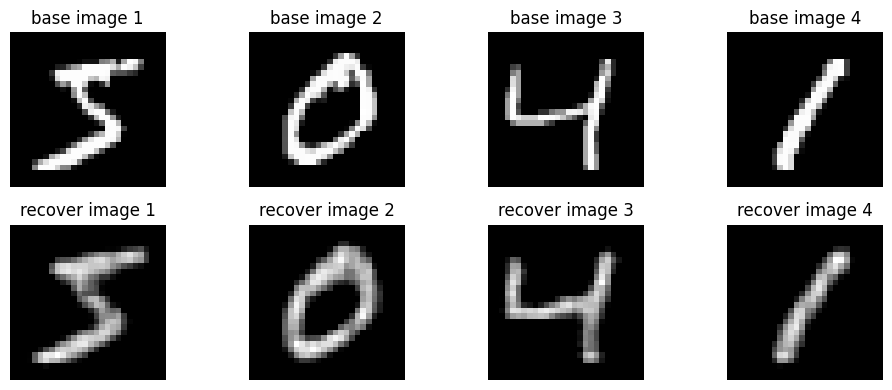

In [18]:
n = 4
x_train_recoverd = autoencoder3.predict(x_train_2d_c[:n, :])
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_train_2d_c[i, :].reshape(28, 28))
    plt.title("base image {}".format(i + 1))
    plt.gray(); plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_recoverd[i, :].reshape(28, 28))
    plt.title("recover image {}".format(i + 1))
    plt.gray(); plt.axis("off")

plt.tight_layout()
plt.show()

In [25]:
from keras.layers import Conv2DTranspose

autoencoder4 = Sequential()

In [29]:
autoencoder4.add(Conv2D(16, 3, input_shape=(28, 28, 1), activation='relu', padding='same'))
autoencoder4.add(MaxPooling2D(2, padding='same'))
autoencoder4.add(Conv2D(32, 3, activation='relu', padding='same'))
autoencoder4.add(MaxPooling2D(2, padding='same'))

autoencoder3.add(UpSampling2D(2))
autoencoder3.add(Conv2D(16, 3, activation='relu', padding='same'))
autoencoder3.add(UpSampling2D(2))
autoencoder3.add(Conv2D(1, 3, activation='relu', padding='same'))
autoencoder4.add(Conv2DTranspose(32, 3, strides=2, padding='same'))
autoencoder4.add(Conv2D(16, 3, activation='relu', padding='same'))
autoencoder4.add(Conv2DTranspose(32, 3, strides=2, padding='same'))
autoencoder4.add(Conv2D(1, 3, activation='relu', padding='same'))

autoencoder4.compile(optimizer="adam", loss="binary_crossentropy")

autoencoder4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 32)       9248      
 ranspose)                                                       
                                                      

In [30]:
history = autoencoder4.fit(x_train_2d_c, x_train_2d_c, 
                           epochs=10, batch_size=256, shuffle=True, verbose=0)

1/1 [==============================] - 0s 143ms/step


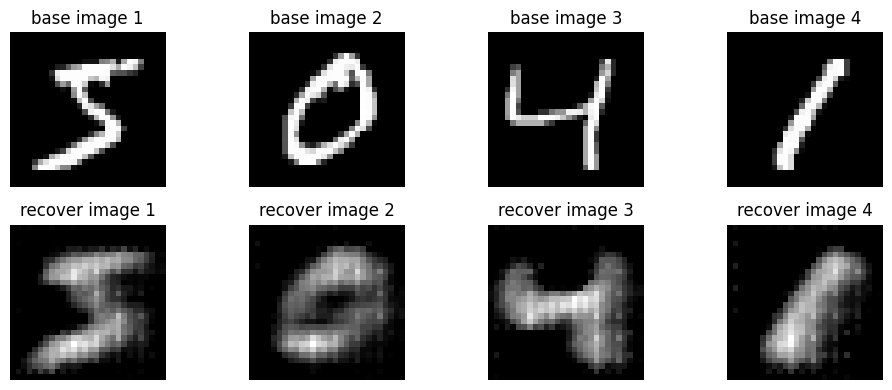

In [31]:
n = 4
x_train_recoverd1 = autoencoder4.predict(x_train_2d_c[:n, :])
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_train_2d_c[i, :].reshape(28, 28))
    plt.title("base image {}".format(i + 1))
    plt.gray(); plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_recoverd1[i, :].reshape(28, 28))
    plt.title("recover image {}".format(i + 1))
    plt.gray(); plt.axis("off")

plt.tight_layout()
plt.show()